## Install Packages

In [33]:
!pip install kneed
!pip install umap-learn matplotlib
!pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Packages

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap
from scipy.linalg import dft
from scipy.stats import kruskal, f_oneway
from scikit_posthocs import posthoc_dunn
from statsmodels.stats.multicomp import pairwise_tukeyhsd


## Load Data

In [35]:
df = pd.read_csv("/content/taxonomic_profiles.tsv", sep="\t")

## Pre-Process

### Set 'Taxonomy' Column as Index

In [36]:
df = df.set_index("taxonomy")

### Transpose

In [37]:
df = df.transpose()

In [38]:
# Drop the first row (OTU ID)
df.drop(df.index[0], inplace=True)

In [39]:
df.head()

taxonomy,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Acetobacteraceae; __Belnapia,Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Comamonadaceae; __Tepidimonas,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Christensenellaceae; __Christensenellaceae_R_7_group,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Family_XIII; __Family_XIII_AD3011_group,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodobacterales; __Rhodobacteraceae; __Paracoccus,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminiclostridium,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Run_SP154; __f; __g,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Pasteurellales; __Pasteurellaceae; __Frederiksenia,Bacteria; __Actinobacteria; __Actinobacteria; __Corynebacteriales; __Corynebacteriaceae; __Corynebacterium_1,...,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Clostridiales_vadinBB60_group; __g,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Tenericutes; __Mollicutes; __Mollicutes_RF9; __f; __g,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Rhodospirillales_Incertae_Sedis; __Candidatus_Alysiosphaera,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcus_1,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Blautia,Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales; __Saprospiraceae; __uncultured,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __uncultured,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_014
206646,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,481.0,0.0,0.0,0.0,0.0
224324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
206619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
224326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
206624,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Keep One Duplicate Column Only

In [40]:
if df.columns.duplicated().any():
    print("There are duplicate column names in the dataframe")
else:
    print("There are no duplicate column names in the dataframe")

There are duplicate column names in the dataframe


In [41]:
df = df.loc[:, ~df.columns.duplicated()]

### Relative Abundance Normalization 

In [42]:
def normalize(row):
    total = row.sum()
    return row / total

df = df.apply(normalize, axis=1)

In [43]:
df.head()

taxonomy,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Acetobacteraceae; __Belnapia,Bacteria; __Proteobacteria; __Betaproteobacteria; __Burkholderiales; __Comamonadaceae; __Tepidimonas,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Christensenellaceae; __Christensenellaceae_R_7_group,Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Prevotellaceae; __Prevotella,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Family_XIII; __Family_XIII_AD3011_group,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodobacterales; __Rhodobacteraceae; __Paracoccus,Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminiclostridium,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Run_SP154; __f; __g,Bacteria; __Proteobacteria; __Gammaproteobacteria; __Pasteurellales; __Pasteurellaceae; __Frederiksenia,Bacteria; __Actinobacteria; __Actinobacteria; __Corynebacteriales; __Corynebacteriaceae; __Corynebacterium_1,...,Bacteria; __Actinobacteria; __Actinobacteria; __Bifidobacteriales; __Bifidobacteriaceae; __Gardnerella,Bacteria; __Actinobacteria; __Actinobacteria; __Micrococcales; __Dermabacteraceae; __Brachybacterium,Bacteria; __Actinobacteria; __Actinobacteria; __Corynebacteriales; __Corynebacteriaceae; __Lawsonella,Bacteria; __Firmicutes; __Erysipelotrichia; __Erysipelotrichales; __Erysipelotrichaceae; __Erysipelotrichaceae_UCG_003,Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales; __Chitinophagaceae; __Lacibacter,Bacteria; __Firmicutes; __Clostridia; __Thermoanaerobacterales; __Family_III; __Thermoanaerobacterium,Bacteria; __Elusimicrobia; __Elusimicrobia; __Lineage_IIc; __f; __g,Bacteria; __Actinobacteria; __Actinobacteria; __Pseudonocardiales; __Pseudonocardiaceae; __Actinomycetospora,Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodospirillales; __Rhodospirillales_Incertae_Sedis; __Candidatus_Alysiosphaera,Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales; __Saprospiraceae; __uncultured
206646,0.000000,0.0,0.0,0.0,0.000126,0.0,0.000253,0.0,0.0,0.00101,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
224324,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
206619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
224326,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.001390,0.0,0.0,0.0,0.0,0.0,0.0
206624,0.029565,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.038261,0.0,0.0,0.0,0.0,0.0,0.0


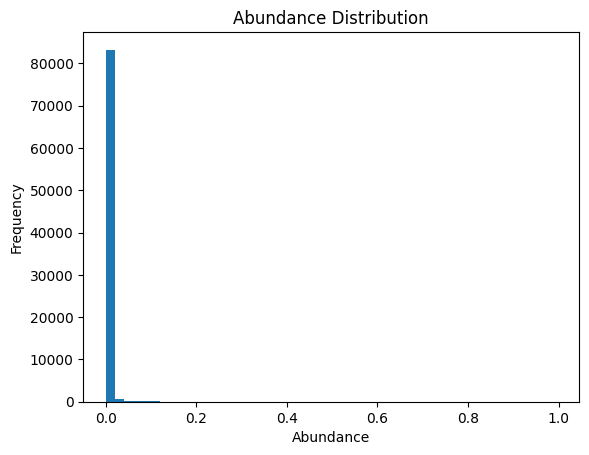

In [44]:
abundance_data = df.values.flatten()  # Extract abundance data from the dataframe
plt.hist(abundance_data, bins=50)  # Create histogram with 50 bins
plt.xlabel('Abundance')  # Set x-axis label
plt.ylabel('Frequency')  # Set y-axis label
plt.title('Abundance Distribution')  # Set plot title
plt.show()  # Display the plot

## Save Pre-Processed to CSV

In [45]:
#df.to_csv('/content/pre_processed_data.csv', index=False)

In [46]:
#df = pd.read_csv("/content/pre_processed_data.csv")

In [47]:
if df.columns.duplicated().any():
    print("There are duplicate column names in the dataframe")
else:
    print("There are no duplicate column names in the dataframe")

There are no duplicate column names in the dataframe


In [48]:
print(df.shape)

(178, 476)


<Axes: xlabel='taxonomy', ylabel='taxonomy'>

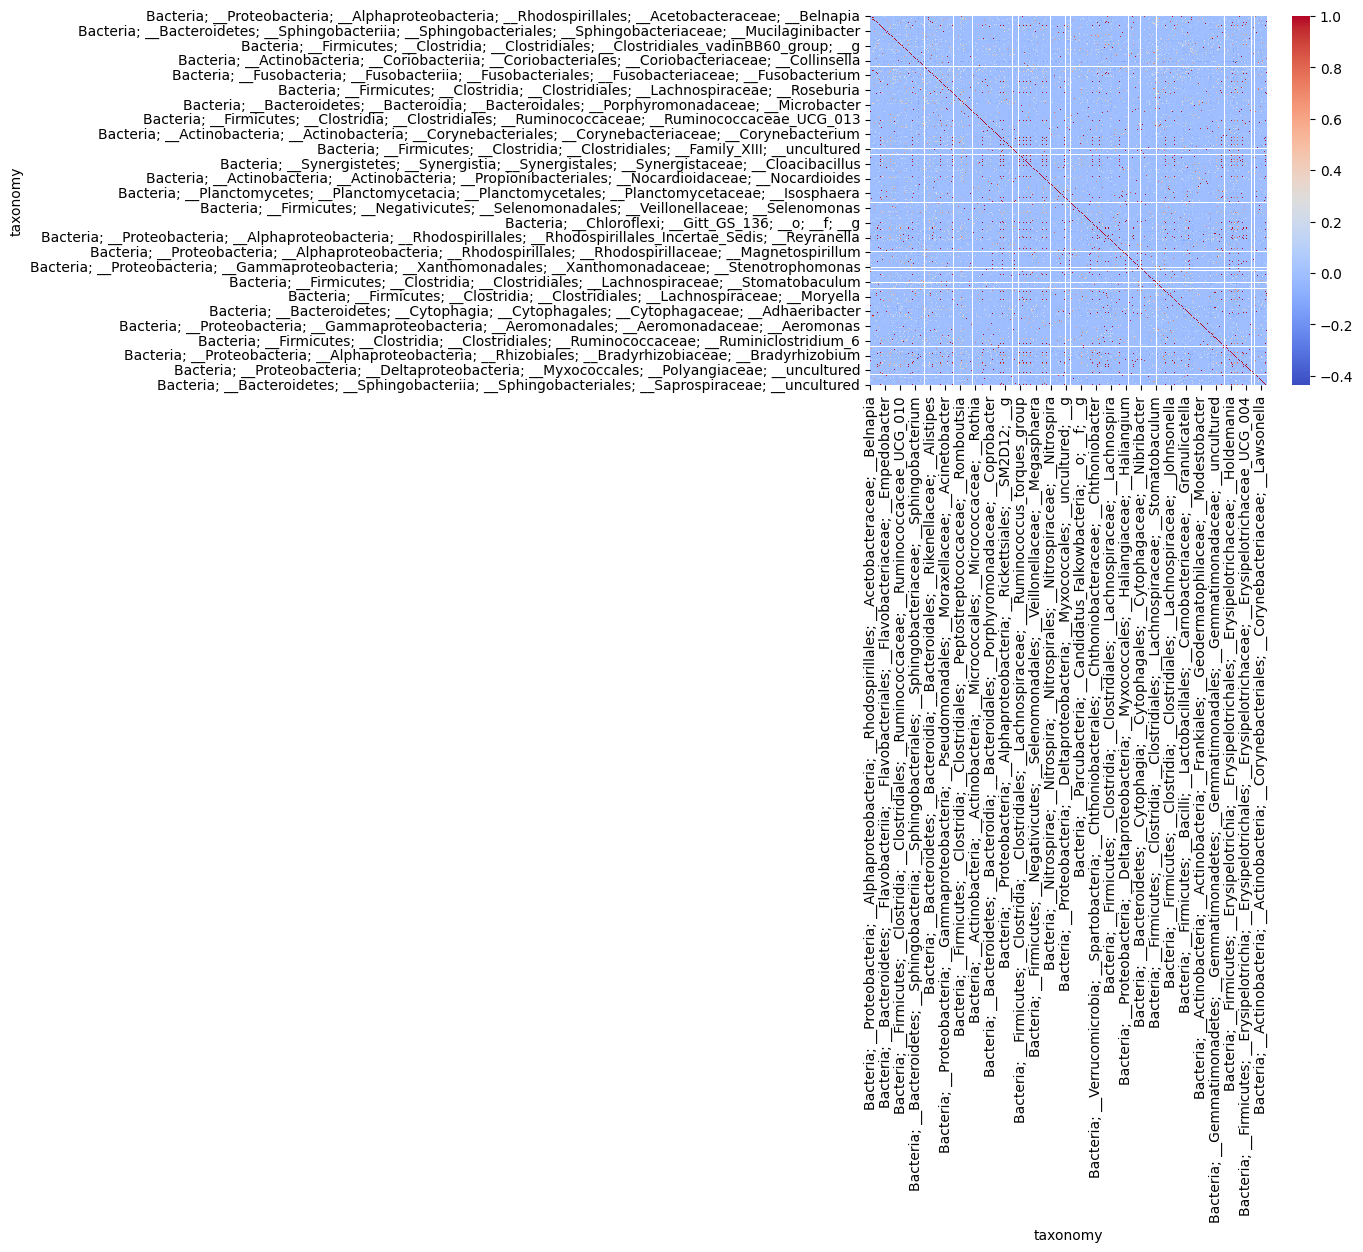

In [49]:
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm')

## K-Means Clustering

### Determine the Optimal Number of Clusters

#### Elbow Plot

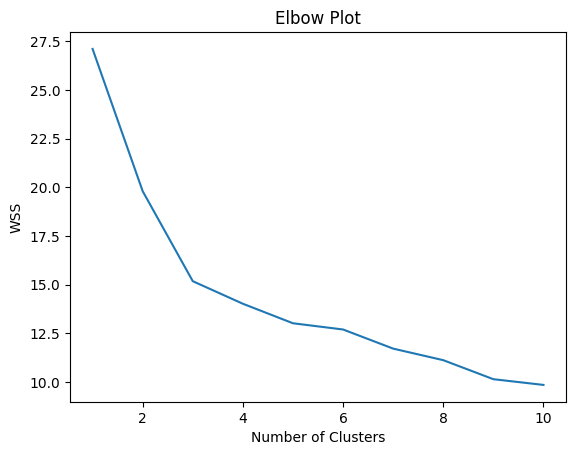

In [50]:
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wss.append(kmeans.inertia_)
plt.plot(range(1, 11), wss)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS')
plt.show()

In [51]:
kl = KneeLocator(range(1, 11), wss, curve="convex", direction="decreasing")
kl.elbow

3

#### Silhouette Coefficient

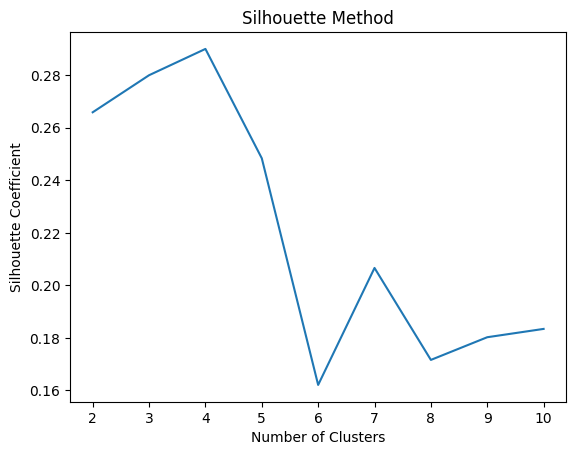

In [52]:
silhouette_coefficients = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.plot(range(2, 11), silhouette_coefficients)
plt.title('Silhouette Method')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Choose k = 3

### K-Means Modeling

In [53]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [54]:
labels = kmeans.labels_
df['cluster'] = labels
cluster_counts = df['cluster'].value_counts()
print(cluster_counts)

1    86
0    72
2    20
Name: cluster, dtype: int64


### Plot Using PCA

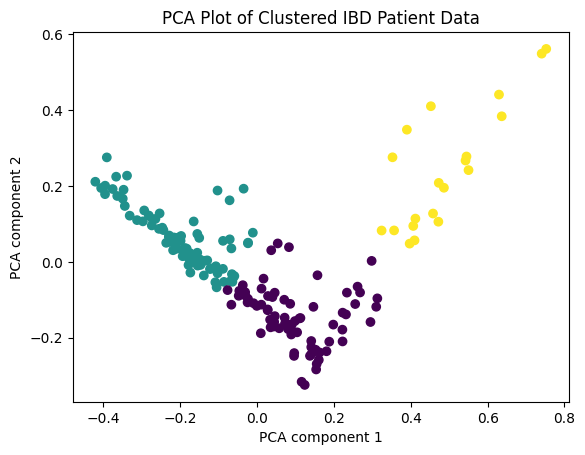

In [55]:
df_pca = df.drop(columns=['cluster'])
pca = PCA(n_components=2)
pca.fit(df_pca)
transformed = pca.transform(df_pca)

# plot the data points with different colors for each cluster
plt.scatter(transformed[:, 0], transformed[:, 1], c=labels)
plt.title("PCA Plot of Clustered IBD Patient Data")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()

### Internal Validation

In [56]:
# compute the Silhouette score
silhouette_avg = silhouette_score(df_pca, labels)

# compute the Davies-Bouldin index
davies_bouldin_idx = davies_bouldin_score(df_pca, labels)

# compute the Calinski-Harabasz index
calinski_harabasz_idx = calinski_harabasz_score(df_pca, labels)

print(f'Silhouette score: {silhouette_avg:.3f}')
print(f'Davies-Bouldin index: {davies_bouldin_idx:.3f}')
print(f'Calinski-Harabasz index: {calinski_harabasz_idx:.3f}')

Silhouette score: 0.280
Davies-Bouldin index: 1.373
Calinski-Harabasz index: 68.827


### Enrichment Analysis (Attempt?)

#### Enrichment df

In [25]:
# Get abundance matrix with bacteria as rows and clusters as columns
# pivot the dataframe
pivoted_df = pd.pivot_table(df, values=df.columns[:-1], index=df.columns[-1], aggfunc='sum')

# transpose the dataframe
enrichment_df = pivoted_df.transpose()

# reset the index
enrichment_df.reset_index(inplace=True)

# rename the columns
enrichment_df.columns = ['Bacteria'] + enrichment_df.columns[1:].tolist()

# set the index to Bacteria column
enrichment_df.set_index('Bacteria', inplace=True)

# rename columns
new_names = ["C1","C2","C3"]
enrichment_df.columns = new_names

# print the resulting dataframe
print(enrichment_df.columns)

Index(['C1', 'C2', 'C3'], dtype='object')


#### Top 5 In Each Cluster

In [26]:
# Define function to get top 5 from a column 
def get_top_5(df, col):
  sorted_df = df.sort_values(by=col, ascending=False)
  top_5 = sorted_df[col].head(5)
  return top_5

C1 = get_top_5(enrichment_df, "C1").index
C2 = get_top_5(enrichment_df, "C2").index
C3 = get_top_5(enrichment_df, "C3").index 

C1_only = set(C1) - set(C2) - set(C3)
C2_only = set(C2) - set(C1) - set(C3)
C3_only = set(C3) - set(C1) - set(C2)
all = set(C1) & set(C2) & set(C3)

print(len(C1_only),"C1 only:", C1_only)
print(len(C2_only),"C2 only:", C2_only)
print(len(C3_only),"C3 only:", C3_only)
print(len(all),"All:", all)






1 C1 only: {'Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia'}
2 C2 only: {'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Anaerostipes', 'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia'}
1 C3 only: {'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Lachnoclostridium'}
3 All: {'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group', 'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group', 'Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides'}


#### Bottom 10 In Each Cluster

In [27]:
def get_bottom_10(df, col):
  sorted_df = df.sort_values(by=col, ascending=True)
  bottom_10 = sorted_df[col].head(10)
  return bottom_10

C1_bottom10 = get_bottom_10(enrichment_df, "C1")  
C2_bottom10 = get_bottom_10(enrichment_df, "C2")
C3_bottom10 = get_bottom_10(enrichment_df, "C3") 

### Feature Importances

In [28]:
feature_names = df.drop(columns=['cluster']).columns 

centroids = kmeans.cluster_centers_
differences = []
for i in range(num_clusters):
    for j in range(i+1, num_clusters):
        diff = np.abs(centroids[i] - centroids[j])
        differences.append(diff)
differences = np.array(differences)
feature_importance = pd.DataFrame(differences.sum(axis=0), columns=['importance'], index=feature_names)
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
feature_importance = feature_importance.loc[~feature_importance.index.duplicated(keep='first')]
print(feature_importance)

                                                    importance
taxonomy                                                      
Bacteria; __Proteobacteria; __Gammaproteobacter...    1.109240
Bacteria; __Bacteroidetes; __Bacteroidia; __Bac...    0.870114
Bacteria; __Firmicutes; __Clostridia; __Clostri...    0.160155
Bacteria; __Firmicutes; __Clostridia; __Clostri...    0.091971
Bacteria; __Verrucomicrobia; __Verrucomicrobiae...    0.085082
...                                                        ...
Bacteria; __Proteobacteria; __Alphaproteobacter...    0.000000
Bacteria; __Nitrospirae; __Nitrospira; __Nitros...    0.000000
Bacteria; __Proteobacteria; __Deltaproteobacter...    0.000000
Bacteria; __Proteobacteria; __Deltaproteobacter...    0.000000
Bacteria; __Cyanobacteria; __Cyanobacteria; __S...    0.000000

[476 rows x 1 columns]


In [32]:
print(feature_importance.index[0:50])

Index(['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella',
       'Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group',
       'Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Roseburia',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; __Anaerostipes',
       'Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Porphyromonadaceae; __Parabacteroides',
       'Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Subdoligranulum',
       'Bacteria; __Pr

## Visualization

### Box Plots

#### Escherichia_Shigella

Text(0.5, 1.0, 'Distribution of Escherichia_Shigella by Cluster')

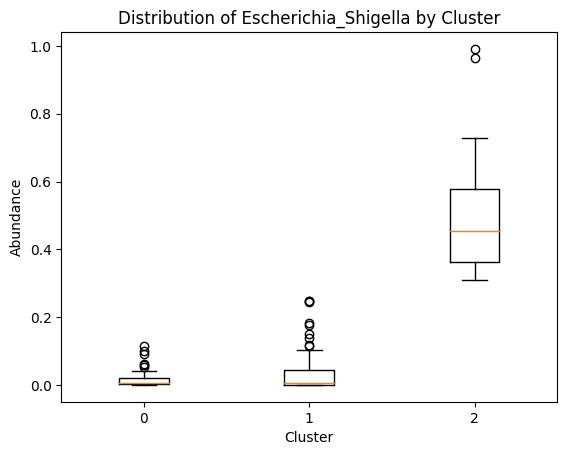

In [ ]:
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Escherichia_Shigella by Cluster')

#### Bacteroides

Text(0.5, 1.0, 'Distribution of Bacteroides by Cluster')

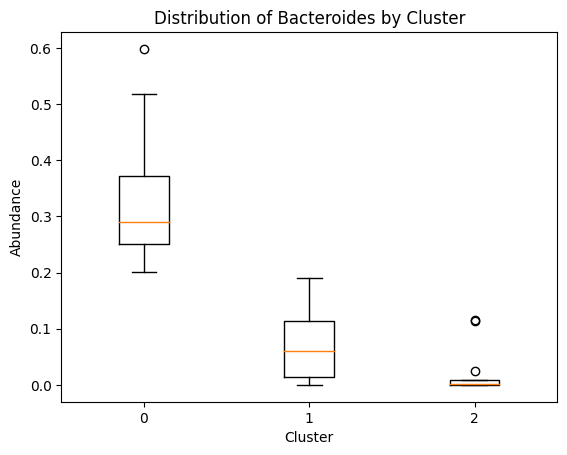

In [ ]:
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Bacteroides by Cluster')

#### Eubacterium_rectale_group

Text(0.5, 1.0, 'Distribution of Eubacterium_rectale_group by Cluster')

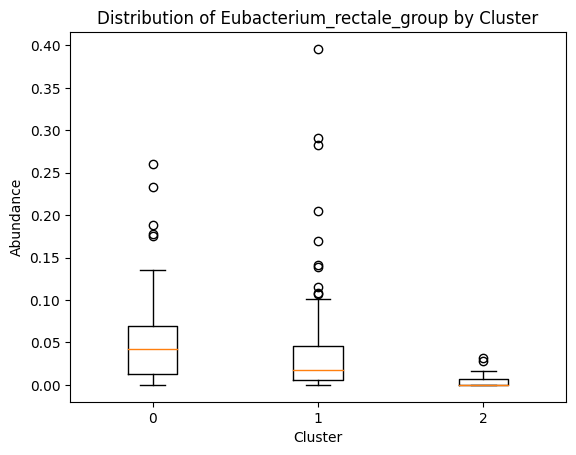

In [ ]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Eubacterium_rectale_group by Cluster')

#### Ruminococcus_gnavus_group

Text(0.5, 1.0, 'Distribution of Ruminococcus_gnavus_group by Cluster')

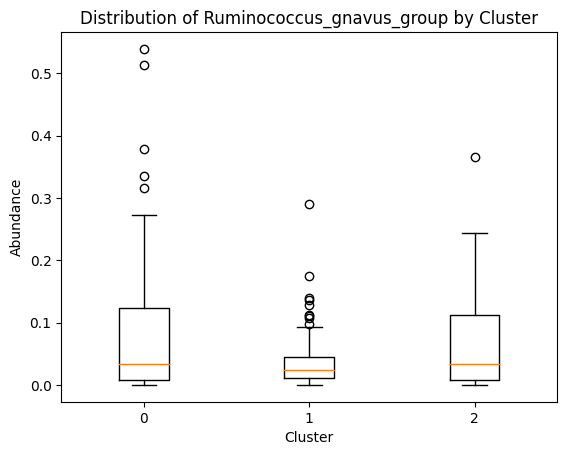

In [ ]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group'
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Ruminococcus_gnavus_group by Cluster')

#### Akkermansia

Text(0.5, 1.0, 'Distribution of Akkermansia  by Cluster')

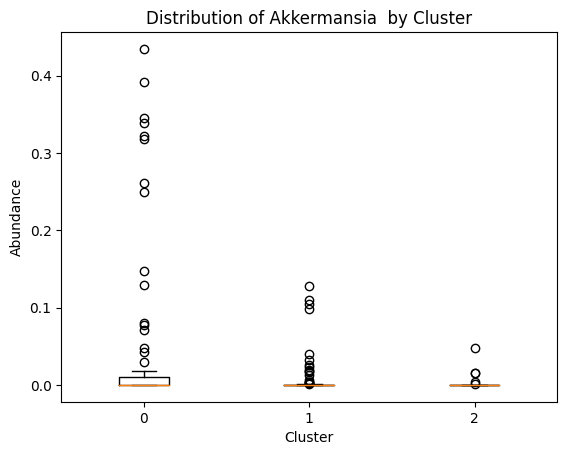

In [ ]:
# Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Akkermansia  by Cluster')

#### Combined Figure

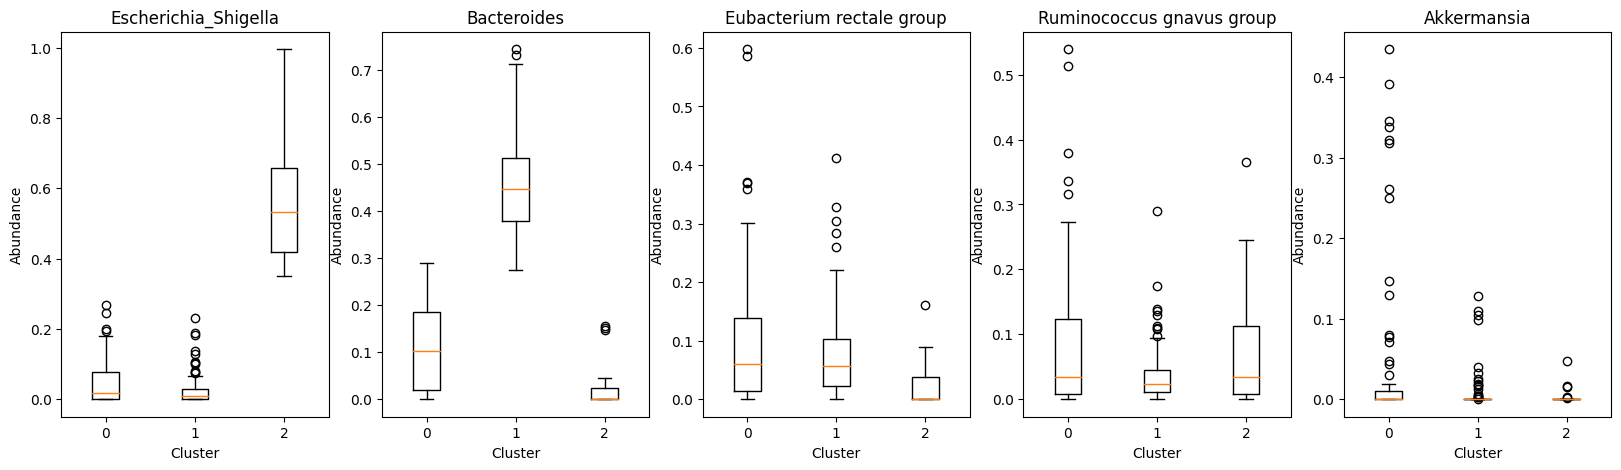

In [104]:
cluster_groups = df.groupby('cluster')

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# Plot the first boxplot
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella'].values for cluster_label in cluster_groups.groups]
ax[0].boxplot(feature_data)
ax[0].set_xticklabels(cluster_groups.groups.keys())
ax[0].set_ylabel('Abundance')
ax[0].set_xlabel('Cluster')
ax[0].set_title('Escherichia_Shigella')

# Plot the second boxplot
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides'].values for cluster_label in cluster_groups.groups]
ax[1].boxplot(feature_data)
ax[1].set_xticklabels(cluster_groups.groups.keys())
ax[1].set_ylabel('Abundance')
ax[1].set_xlabel('Cluster')
ax[1].set_title('Bacteroides')

# Plot the third boxplot
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Eubacterium_rectale_group'].values for cluster_label in cluster_groups.groups]
ax[2].boxplot(feature_data)
ax[2].set_xticklabels(cluster_groups.groups.keys())
ax[2].set_ylabel('Abundance')
ax[2].set_xlabel('Cluster')
ax[2].set_title('Eubacterium rectale group')

# Plot the fourth boxplot
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group'].values for cluster_label in cluster_groups.groups]
ax[3].boxplot(feature_data)
ax[3].set_xticklabels(cluster_groups.groups.keys())
ax[3].set_ylabel('Abundance')
ax[3].set_xlabel('Cluster')
ax[3].set_title('Ruminococcus gnavus group')

# Plot the fifth boxplot
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia'].values for cluster_label in cluster_groups.groups]
ax[4].boxplot(feature_data)
ax[4].set_xticklabels(cluster_groups.groups.keys())
ax[4].set_ylabel('Abundance')
ax[4].set_xlabel('Cluster')
ax[4].set_title('Akkermansia')


plt.show()


## UMAP

### Plotting

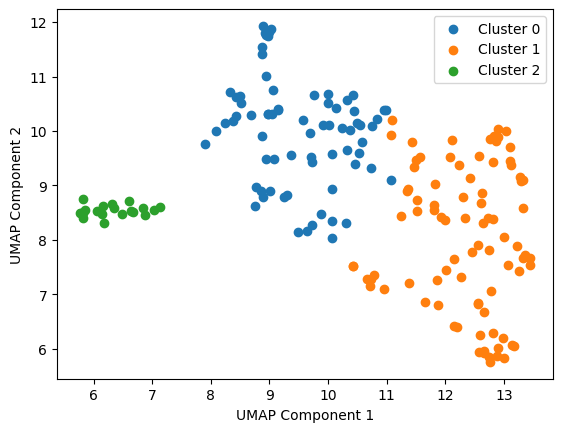

In [106]:
cluster_labels = df['cluster'].values
df_umap = df.drop(columns=['cluster'])

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(df_umap)

# Create a scatter plot with colored points
unique_labels = np.unique(cluster_labels)
for label in unique_labels:
    plt.scatter(embedding[cluster_labels == label, 0], 
                embedding[cluster_labels == label, 1], 
                label='Cluster {}'.format(label))

# Add a legend to show the cluster labels
plt.legend()

# Set axis labels
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Show the plot
plt.show()


### Feature Importance

In [ ]:
corr_matrix = np.corrcoef(df_umap.T, embedding.T)
# print(len(corr_matrix))
importance_scores = np.abs(corr_matrix[:-2, -2:])
# print(len(importance_scores))
feature_names = df_umap.columns
# print(len(feature_names))
feature_importance = pd.DataFrame(importance_scores.T, columns=feature_names)
feature_ranking = feature_importance.mean().sort_values(ascending=False)
print(feature_ranking)

taxonomy
Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides                              0.756443
Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella    0.434956
Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia             0.296626
Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group                  0.262722
Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005                     0.208998
                                                                                                                          ...   
Bacteria; __Actinobacteria; __Actinobacteria; __Micrococcales; __Micrococcaceae; __Enteractinococcus                         NaN
Bacteria; __Proteobacteria; __Betaproteobacteria; __Neisseriales; __Neisseriaceae; __Vog

In [ ]:
print(feature_ranking.index[4])

Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005


#### Bacteroides

Text(0.5, 1.0, 'Distribution of Bacteroides by Cluster')

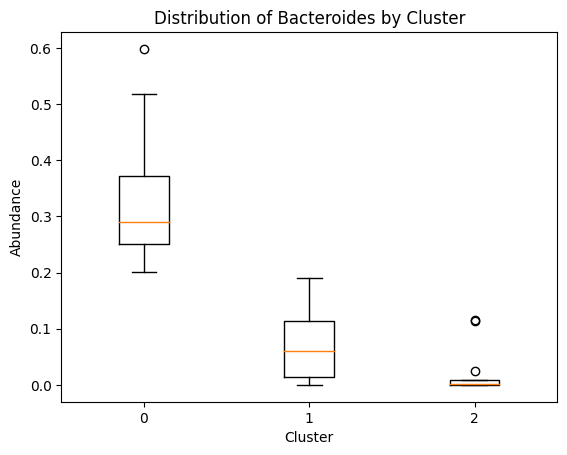

In [ ]:
# Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Bacteroidetes; __Bacteroidia; __Bacteroidales; __Bacteroidaceae; __Bacteroides'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Bacteroides by Cluster')

#### Escherichia_Shigella

Text(0.5, 1.0, 'Distribution of Escherichia_Shigella by Cluster')

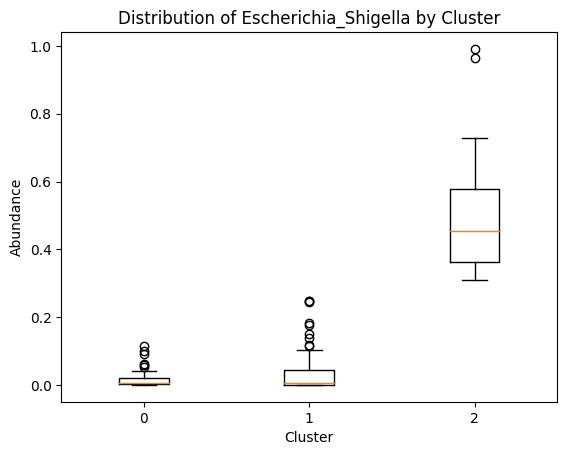

In [ ]:
# Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Proteobacteria; __Gammaproteobacteria; __Enterobacteriales; __Enterobacteriaceae; __Escherichia_Shigella'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Escherichia_Shigella by Cluster')

#### Akkermansia 

Text(0.5, 1.0, 'Distribution of Akkermansia  by Cluster')

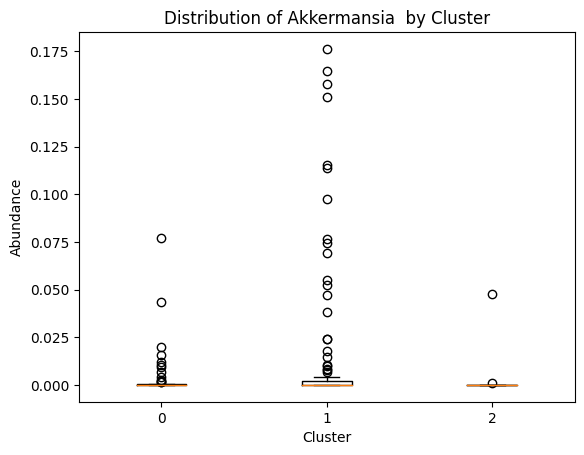

In [ ]:
# Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Verrucomicrobia; __Verrucomicrobiae; __Verrucomicrobiales; __Verrucomicrobiaceae; __Akkermansia'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Akkermansia  by Cluster')

#### Ruminococcaceae_UCG_005


Text(0.5, 1.0, 'Distribution of Ruminococcaceae_UCG_005  by Cluster')

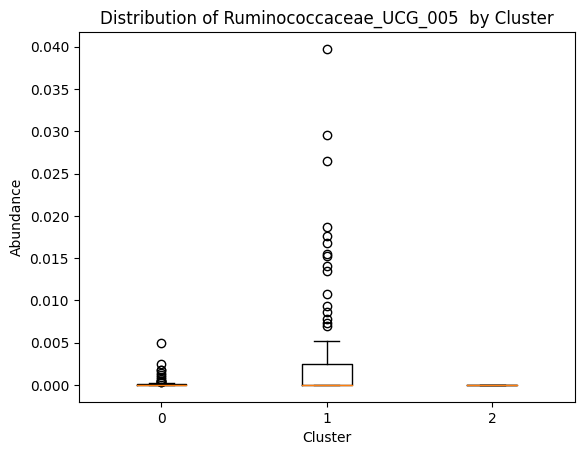

In [ ]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Ruminococcaceae; __Ruminococcaceae_UCG_005'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Ruminococcaceae_UCG_005  by Cluster')

#### Ruminococcus_gnavus_group

Text(0.5, 1.0, 'Distribution of Ruminococcus_gnavus_group by Cluster')

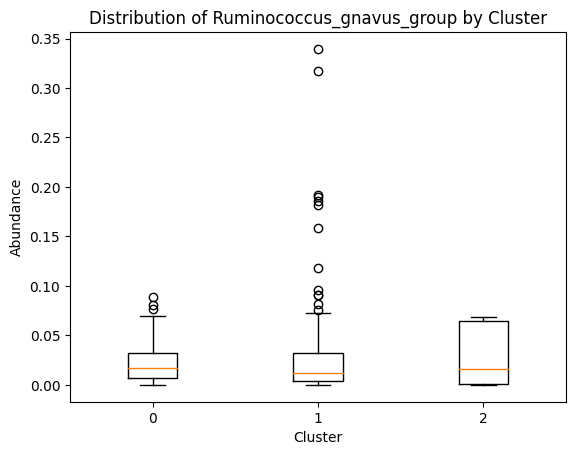

In [ ]:
# Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group
cluster_groups = df.groupby('cluster')
feature_data = [cluster_groups.get_group(cluster_label)['Bacteria; __Firmicutes; __Clostridia; __Clostridiales; __Lachnospiraceae; ___Ruminococcus_gnavus_group'].values for cluster_label in cluster_groups.groups]
fig, ax = plt.subplots()
ax.boxplot(feature_data)
ax.set_xticklabels(cluster_groups.groups.keys())
ax.set_ylabel('Abundance')
ax.set_xlabel('Cluster')
ax.set_title('Distribution of Ruminococcus_gnavus_group by Cluster')